# Comparison between OT and GW registration methods

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.io import loadmat
from IPython.display import HTML

from otimage import imagerep, readers
from otimage.utils import plot_maxproj
from otimage.imagereg import ot_registration, gw_registration

## Load Zimmer data

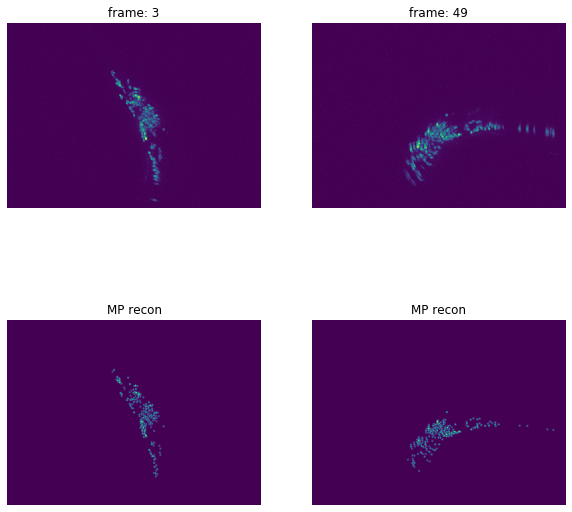

In [3]:
# Frame index
t1 = 3
t2 = 49

# Load two successive frames from dataset
img_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'
with readers.ZimmerReader(img_path) as reader:
    img_1 = reader.get_frame(t1)
    img_2 = reader.get_frame(t2)
    img_shape = img_1.shape

# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.mat'
mp_data = loadmat(mp_path)
cov = mp_data['cov']
pts_1 = mp_data['means'][t1, :, :]
pts_2 = mp_data['means'][t2, :, :]
wts_1 = mp_data['weights'][t1, :, 0]
wts_2 = mp_data['weights'][t2, :, 0]

# Reconstruct images from MPs
rec_1 = imagerep.reconstruct_image(pts_1, [cov], wts_1, img_shape)
rec_2 = imagerep.reconstruct_image(pts_2, [cov], wts_2, img_shape)
  
plt.figure(figsize=(10, 10))

plt.subplot(221)
plot_maxproj(img_1)
plt.title(f'frame: {t1}')
plt.axis('off')

plt.subplot(222)
plot_maxproj(img_2)
plt.title(f'frame: {t2}')
plt.axis('off');

plt.subplot(223)
plot_maxproj(rec_1)
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj(rec_2)
plt.title('MP recon')
plt.axis('off');

## Compute registrations for images

In [4]:
degree = 2
n_iter = 50

model, debug = gw_registration(pts_1, pts_2, wts_1, wts_2, degree=degree, n_iter=n_iter)

alpha = model.named_steps['linear'].intercept_
beta = model.named_steps['linear'].coef_

print('alpha (est):')
print(alpha)
print('beta (est):')
print(beta)

alpha (est):
[15221.60182418 -1883.7655595    739.19643103]
beta (est):
[[ 6.05199708e-27 -4.15169909e+01 -2.60381124e+01 -7.82416401e+01
   2.99411269e-02  3.57531388e-02  9.73872354e-02  1.08393949e-02
   8.79340675e-02  7.19798641e-02]
 [ 5.72872902e-28  7.73501182e+00  1.84778479e+00 -2.63339334e+01
  -6.93119570e-03 -3.23261061e-03  4.87183973e-02 -7.64893224e-04
   1.23531548e-02 -1.33357514e-02]
 [ 1.93164257e-28 -2.13543531e+00 -1.09361484e+00 -1.20800918e+00
   1.55145736e-03  1.71256257e-03  2.59890891e-04  2.83509937e-04
   2.38710735e-03  1.07087479e-02]]


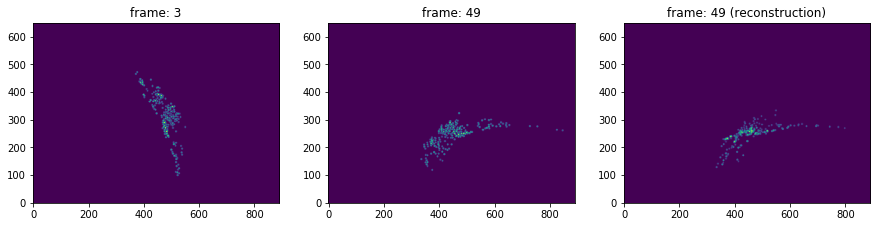

In [5]:
# Transform MP points for first image using mapping
pf_pts = model.predict(pts_1).astype(int)

# Reconstruct image from transformed points
rec_pf = imagerep.reconstruct_image_2(pf_pts, wts_1, cov, img_shape)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(rec_1)
plt.title(f'frame: {t1}')
        
plt.subplot(132)
plot_maxproj(rec_2)
plt.title(f'frame: {t2}')
        
plt.subplot(133)
plot_maxproj(rec_pf)
plt.title(f'frame: {t2} (reconstruction)');

## Plot transformation Jacobians

In [6]:
def compute_jac_quad(x, beta):
    """Compute Jacobian matrix for quadratic transform."""
    
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    
    d_phi = np.array([
        [0,         0,         0        ],
        [1,         0,         0        ],
        [0,         1,         0        ], 
        [0,         0,         1        ],
        [2 * x0,    0,         0        ],
        [x1,        x0,        0        ],
        [x2,        0,         x0       ],
        [0,         2 * x1,    0        ],
        [0,         x2,        x1       ],
        [0,         0,         2 * x2   ],
    ])
        
    return beta @ d_phi

def compute_jac_cubic(x, beta):
    """Compute Jacobian matrix for cubic transform."""
    
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    
    x0_2 = x0 ** 2
    x1_2 = x1 ** 2
    x2_2 = x2 ** 2
    
    x0_x1 = x0 * x1
    x1_x2 = x1 * x2
    x0_x2 = x0 * x2
    
    d_phi = np.array([
        [0,         0,         0        ],
        [1,         0,         0        ],
        [0,         1,         0        ], 
        [0,         0,         1        ],
        [2 * x0,    0,         0        ],
        [x1,        x0,        0        ],
        [x2,        0,         x0       ],
        [0,         2 * x1,    0        ],
        [0,         x2,        x1       ],
        [0,         0,         2 * x2   ],
        [3 * x0_2,  0,         0        ],
        [2 * x0_x1, x0_2,      0        ],
        [2 * x0_x2, 0,         x0_2     ],
        [x1_2,      2 * x0_x1, 0        ],
        [x1_x2,     x0_x2,     x0_x1    ],
        [x2_2,      0,         2 * x0_x2],
        [0,         3 * x1_2,  0        ],
        [0,         2 * x1_x2, x1_2     ],
        [0,         x2_2,      2 * x1_x2],
        [0,         0,         3 * x2_2 ],
    ])
    
    return beta @ d_phi

def compute_jac_det(x, beta, degree):
    """Compute determinant of Jacobian for polynomial transform"""
    
    if degree == 2:
        compute_jac = compute_jac_quad
    elif degree == 3:
        compute_jac = compute_jac_cubic
    else:
        raise NotImplementedError()
    
    dets = [np.linalg.det(compute_jac(x[i, :], beta)) for i in range(x.shape[0])]
    
    return np.array(dets).reshape(-1, 1)

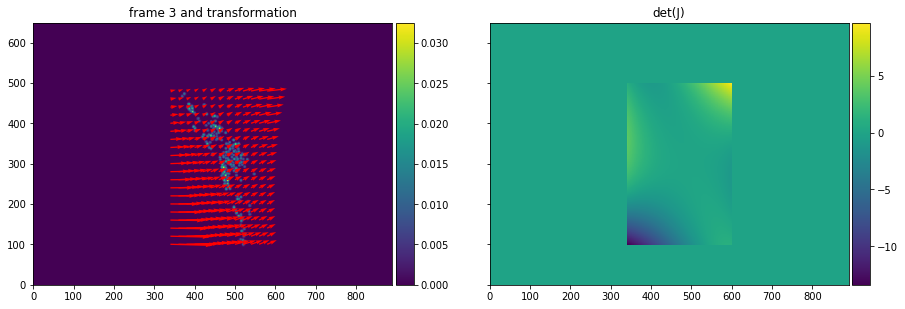

In [7]:
# Window surrounding worm
xlim = (340, 600)
ylim = (100, 500)
zval = 10

# Grid for vector field plotting
x_vf, y_vf = np.mgrid[xlim[0]:xlim[1]:20, ylim[0]:ylim[1]:20]
vf_shape = x_vf.shape
z_vf = np.ones(vf_shape) * zval
vf_grid = np.concatenate(
    [x_vf.reshape(-1, 1), y_vf.reshape(-1, 1), z_vf.reshape(-1, 1)], 
    axis=1
)

# Vector field
v_grid = model.predict(vf_grid)
vx = v_grid[:, 0].reshape(vf_shape)
vy = v_grid[:, 1].reshape(vf_shape)
vz = v_grid[:, 2].reshape(vf_shape)

# Grid for Jacobian plotting
x_jac, y_jac = np.mgrid[xlim[0]:xlim[1], ylim[0]:ylim[1]]
jac_shape = x_jac.shape
z_jac = np.ones(jac_shape) * zval
jac_grid = np.concatenate(
    [x_jac.reshape(-1, 1), y_jac.reshape(-1, 1), z_jac.reshape(-1, 1)], 
    axis=1
)

# Compute determinants of Jacobians on grid
jac_dets = compute_jac_det(jac_grid, beta, degree=degree)
jac_dets_plt = np.zeros((rec_1.shape[0], rec_1.shape[1]))
jac_dets_plt[xlim[0]:xlim[1], ylim[0]:ylim[1]] = jac_dets.reshape(jac_shape)


fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 15))

# Plot vector field
im1 = plot_maxproj(rec_1, ax=ax1)
ax1.quiver(x_vf, y_vf, vx, vy, color='red')
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
ax1.set_title(f'frame {t1} and transformation')

im2 = ax2.imshow(jac_dets_plt.T, origin='lower')
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')
ax2.set_title('det(J)');